# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings_Augmented/ResNet50V2_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1    2         3         4    5         6    7    8  \
41001 201546 -1.0 -0.860426 -1.0 -0.891535 -0.951122 -1.0 -1.000000 -1.0 -1.0   
      201547 -1.0 -0.986925 -1.0 -0.957947 -0.671047 -1.0 -0.970670 -1.0 -1.0   
      201548 -1.0 -0.986925 -1.0 -0.957947 -0.671047 -1.0 -0.970670 -1.0 -1.0   
      201549 -1.0 -0.970098 -1.0 -1.000000 -0.979269 -1.0 -0.985169 -1.0 -1.0   
      201550 -1.0 -1.000000 -1.0 -0.909971 -0.854131 -1.0 -0.980093 -1.0 -1.0   

                     9  ...      2039      2040  2041  2042      2043  \
41001 201546 -0.985063  ... -0.417426 -0.909493  -1.0  -1.0 -0.487635   
      201547 -0.997454  ... -1.000000 -0.660517  -1.0  -1.0 -0.411829   
      201548 -0.997454  ... -1.000000 -0.660517  -1.0  -1.0 -0.411829   
      201549 -1.000000  ... -1.000000 -0.775001  -1.0  -1.0 -0.703727   
      201550 -0.955560  ... -1.000000 -0.844676  -1.0  -1.0 -0.709011   

                  2044  2045      2046      2047    Labels  
41001 201546 -0.909150  -1.0 -0.721187 -0.906836 -0.861740  
      201547 -0.922754  -1.0 -0.707864 -1.000000 -0.854589  
      201548 -0.922754  -1.0 -0.707864 -1.000000 -0.856973  
      201549 -0.913780  -1.0 -0.796910 -1.000000 -0.856973  
      201550 -0.917570  -1.0 -0.332116 -0.931627 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3        4    5         6  \
41001 201820 -1.000000 -0.901166 -0.962204 -1.000000 -1.00000 -1.0 -0.949559   
      201821 -1.000000 -0.980982 -0.981087 -1.000000 -0.96098 -1.0 -1.000000   
      201822 -0.931402 -0.950784 -0.980781 -0.992665 -1.00000 -1.0 -0.755983   
      201823 -1.000000 -1.000000 -0.905623 -1.000000 -1.00000 -1.0 -1.000000   
      201824 -1.000000 -1.000000 -1.000000 -1.000000 -1.00000 -1.0 -0.949448   

                     7         8         9  ...      2039      2040      2041  \
41001 201820 -1.000000 -1.000000 -1.000000  ... -1.000000 -0.955383 -1.000000   
      201821  0.081811 -1.000000 -0.718117  ... -0.926812  0.518692 -1.000000   
      201822 -0.612792 -0.952944 -0.979325  ... -0.974659  0.021307 -1.000000   
      201823 -1.000000 -1.000000 -0.854323  ... -1.000000 -0.932421  1.005799   
      201824 -1.000000 -1.000000 -1.000000  ... -1.000000 -0.818021 -1.000000   

              2042      2043      2044  2045      2046      2047    Labels  
41001 201820  -1.0 -0.849818 -0.186112  -1.0 -0.268471 -1.000000 -0.949940  
      201821  -1.0 -0.852027 -1.000000  -1.0 -0.459775 -0.982723 -0.961859  
      201822  -1.0 -0.957197 -1.000000  -1.0 -0.399741 -0.765866 -0.940405  
      201823  -1.0 -0.919278 -0.798948  -1.0 -0.516460 -1.000000 -0.961859  
      201824  -1.0 -0.911669 -1.000000  -1.0 -0.555354 -1.000000 -0.954708  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 2049)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 2048)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 2048)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

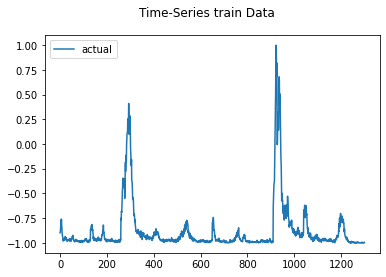

2023-03-13 21:23:32.869256: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-13 21:23:32.869306: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 21:23:32.869334: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-13 21:23:32.869554: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 21:23:33.102931: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 77.555
Test RMSE: 510.139
Test sMAPE: 113.805
Test R Squared: -268.289
{'mae': 77.55531590743499, 'rmse': 510.1387918297109, 'smape': 113.80515411449389, 'r2': -268.2890537313326}


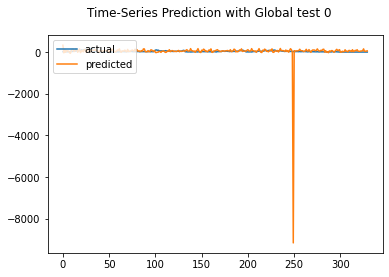

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 246.197
Test RMSE: 353.610
Test sMAPE: 156.512
Test R Squared: -128.387
{'mae': 246.19739476189469, 'rmse': 353.6104399181445, 'smape': 156.51228994298387, 'r2': -128.38745148690728}


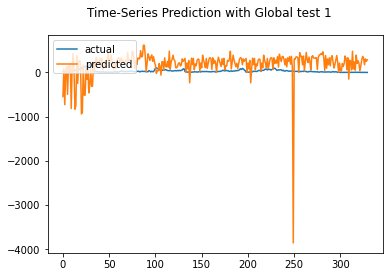

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 92.323
Test RMSE: 138.280
Test sMAPE: 129.165
Test R Squared: -18.786
{'mae': 92.32311152761633, 'rmse': 138.27955972966382, 'smape': 129.16462158393264, 'r2': -18.785998776946247}


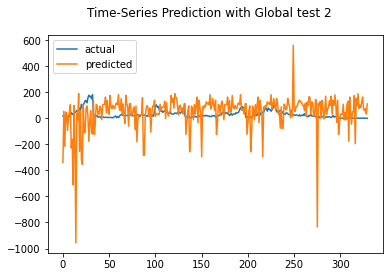

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 272.330
Test RMSE: 297.719
Test sMAPE: 192.321
Test R Squared: -90.718
{'mae': 272.33040816783904, 'rmse': 297.71891883717404, 'smape': 192.32068439587113, 'r2': -90.71806168608028}


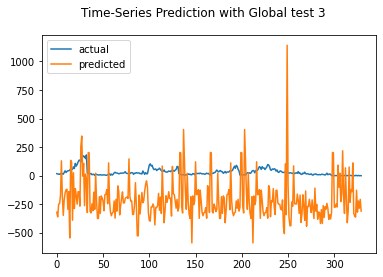

Test MAE: 167.401
Test RMSE: 1429.097
Test sMAPE: 121.884
Test R Squared: -2112.320
{'mae': 167.40133579138555, 'rmse': 1429.0966564161097, 'smape': 121.88433308661435, 'r2': -2112.3197313726505}


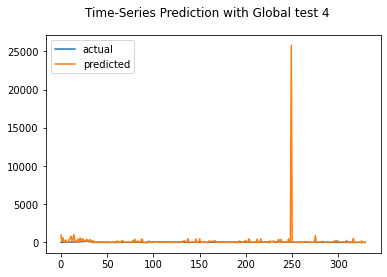

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 136.609
Test RMSE: 184.210
Test sMAPE: 141.027
Test R Squared: -34.113
{'mae': 136.60937120408724, 'rmse': 184.2103706394851, 'smape': 141.026995595627, 'r2': -34.11317932076026}


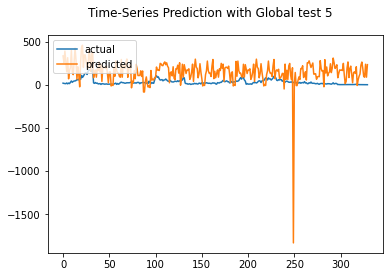

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 83.632
Test RMSE: 173.375
Test sMAPE: 138.344
Test R Squared: -30.104
{'mae': 83.63176826491501, 'rmse': 173.3746614452712, 'smape': 138.34422363359016, 'r2': -30.103785890934073}


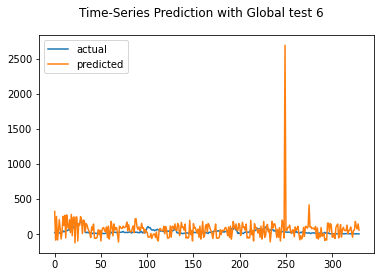

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 76.209
Test RMSE: 94.066
Test sMAPE: 120.819
Test R Squared: -8.156
{'mae': 76.20881764744267, 'rmse': 94.06586899667428, 'smape': 120.8192549236904, 'r2': -8.156007622049863}


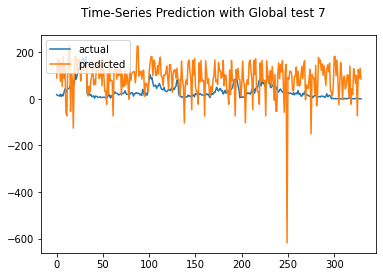

Test MAE: 91.788
Test RMSE: 719.009
Test sMAPE: 114.832
Test R Squared: -533.947
{'mae': 91.78816181818644, 'rmse': 719.0092929281396, 'smape': 114.83245014102475, 'r2': -533.9473108566824}


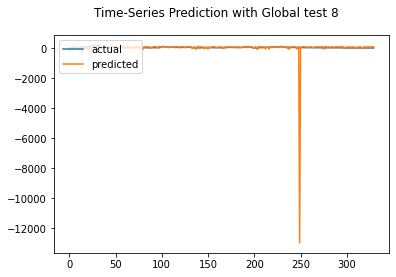

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 74.832
Test RMSE: 365.943
Test sMAPE: 118.070
Test R Squared: -137.570
{'mae': 74.83156517599568, 'rmse': 365.94298043615635, 'smape': 118.07008681973402, 'r2': -137.56988081629282}


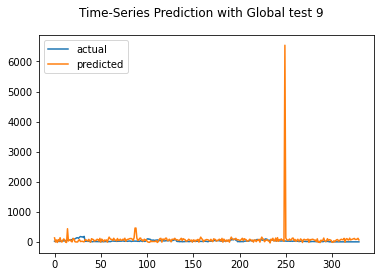

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 51.231
Test RMSE: 64.818
Test sMAPE: 113.358
Test R Squared: -3.347
{'mae': 51.23141140143077, 'rmse': 64.81770069090663, 'smape': 113.35783624872239, 'r2': -3.347396423298944}


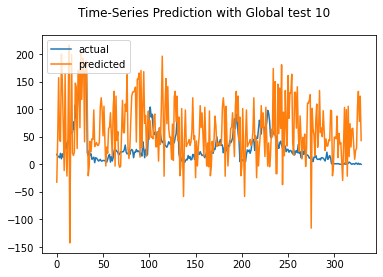

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 203.483
Test RMSE: 669.595
Test sMAPE: 156.085
Test R Squared: -462.946
{'mae': 203.4832740303242, 'rmse': 669.5954760993171, 'smape': 156.085430049342, 'r2': -462.94556051017196}


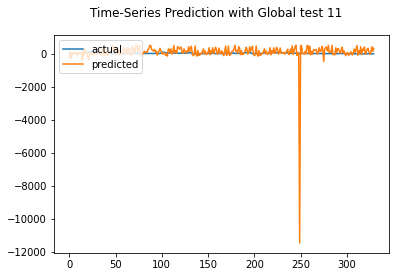

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 159.409
Test RMSE: 263.019
Test sMAPE: 143.398
Test R Squared: -70.584
{'mae': 159.4092505758459, 'rmse': 263.018926285694, 'smape': 143.39811339366452, 'r2': -70.58400664269944}


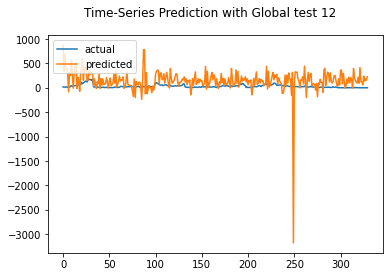

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 336.568
Test RMSE: 1068.290
Test sMAPE: 157.872
Test R Squared: -1179.919
{'mae': 336.5677581498117, 'rmse': 1068.2898541458435, 'smape': 157.87190413095414, 'r2': -1179.9192696280684}


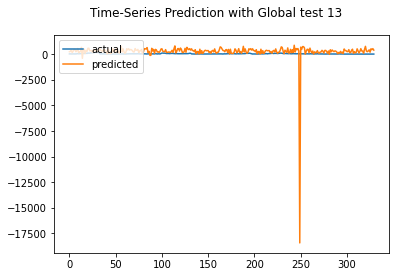

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 58.610
Test RMSE: 86.525
Test sMAPE: 120.579
Test R Squared: -6.747
{'mae': 58.60993526126399, 'rmse': 86.5249346553271, 'smape': 120.57905714567045, 'r2': -6.746839559502346}


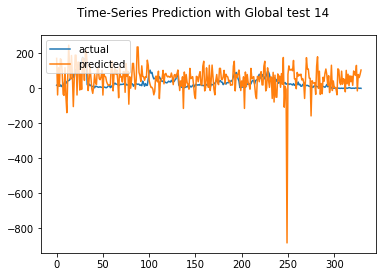

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 163.829
Test RMSE: 417.804
Test sMAPE: 160.269
Test R Squared: -179.629
{'mae': 163.82944950587822, 'rmse': 417.80379145182326, 'smape': 160.26911865746766, 'r2': -179.62869954445296}


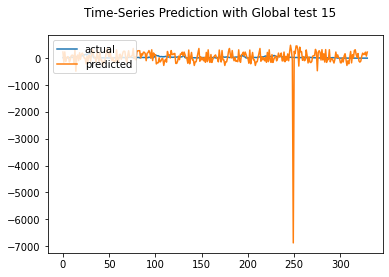

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 68.069
Test RMSE: 112.632
Test sMAPE: 117.688
Test R Squared: -12.127
{'mae': 68.0687694786173, 'rmse': 112.63163657609886, 'smape': 117.68767555794005, 'r2': -12.126918560224164}


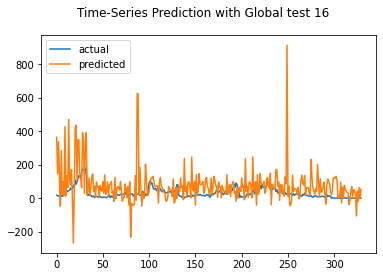

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 704.061
Test RMSE: 1421.726
Test sMAPE: 199.848
Test R Squared: -2090.575
{'mae': 704.0613609313965, 'rmse': 1421.725509513012, 'smape': 199.8484232765573, 'r2': -2090.575343060336}


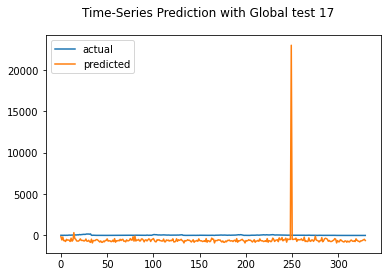

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 135.962
Test RMSE: 265.566
Test sMAPE: 154.984
Test R Squared: -71.977
{'mae': 135.9616210785779, 'rmse': 265.5658620697568, 'smape': 154.9841156463077, 'r2': -71.97708215345867}


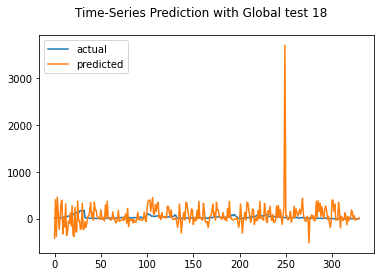

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 1035.920
Test RMSE: 1615.560
Test sMAPE: 199.458
Test R Squared: -2699.773
{'mae': 1035.9198388764353, 'rmse': 1615.559958758641, 'smape': 199.45809192602331, 'r2': -2699.773496912257}


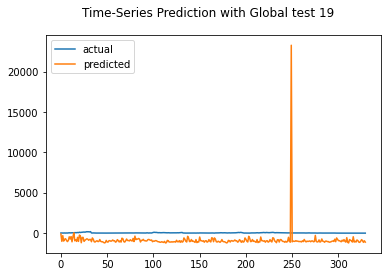

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 568.043
Test RMSE: 799.284
Test sMAPE: 189.152
Test R Squared: -660.065
{'mae': 568.0425535563267, 'rmse': 799.2841739030214, 'smape': 189.15159292335974, 'r2': -660.0654038495509}


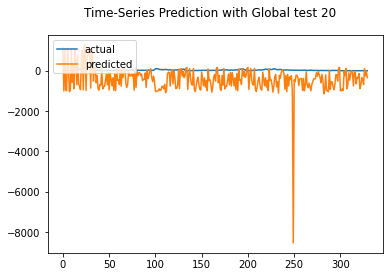

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 107.144
Test RMSE: 143.205
Test sMAPE: 158.841
Test R Squared: -20.221
{'mae': 107.14395428137345, 'rmse': 143.2054277439632, 'smape': 158.8413036291217, 'r2': -20.220761253782836}


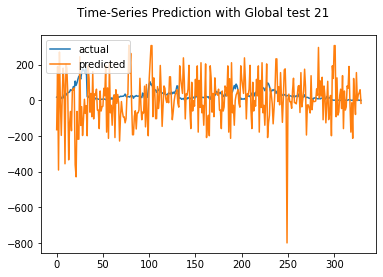

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 189.026
Test RMSE: 326.574
Test sMAPE: 156.910
Test R Squared: -109.358
{'mae': 189.0257576277762, 'rmse': 326.5740367149458, 'smape': 156.9103486587205, 'r2': -109.3583784778637}


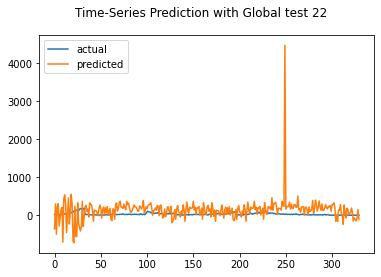

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 75.855
Test RMSE: 107.311
Test sMAPE: 128.683
Test R Squared: -10.916
{'mae': 75.85542311289093, 'rmse': 107.31068162495934, 'smape': 128.6826523854907, 'r2': -10.915929047987552}


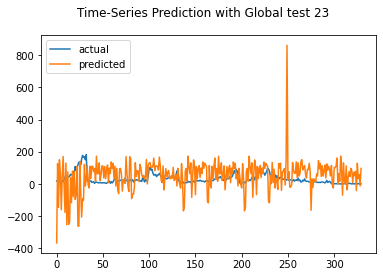

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 71.622
Test RMSE: 134.288
Test sMAPE: 117.035
Test R Squared: -17.660
{'mae': 71.62178153774956, 'rmse': 134.2875938807523, 'smape': 117.03531030695648, 'r2': -17.660092247254468}


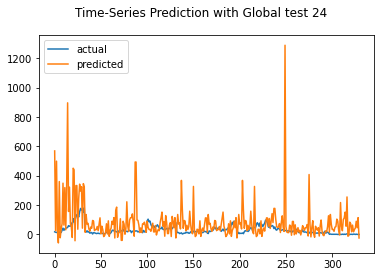

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 152.769
Test RMSE: 179.902
Test sMAPE: 145.932
Test R Squared: -32.490
{'mae': 152.76926440903634, 'rmse': 179.9017037798971, 'smape': 145.93166759374347, 'r2': -32.48980003942448}


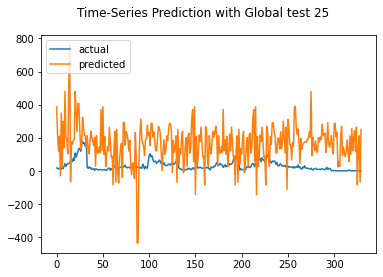

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 755.263
Test RMSE: 882.992
Test sMAPE: 184.682
Test R Squared: -805.781
{'mae': 755.2634226481119, 'rmse': 882.9923205686473, 'smape': 184.6816688025962, 'r2': -805.7813582108762}


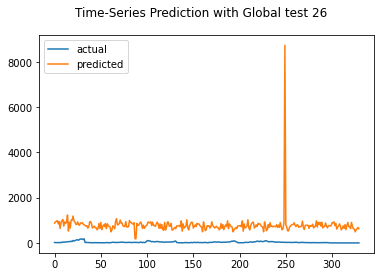

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 224.752
Test RMSE: 348.073
Test sMAPE: 163.343
Test R Squared: -124.367
{'mae': 224.75185817082723, 'rmse': 348.07268096323065, 'smape': 163.34349153264336, 'r2': -124.36660882399089}


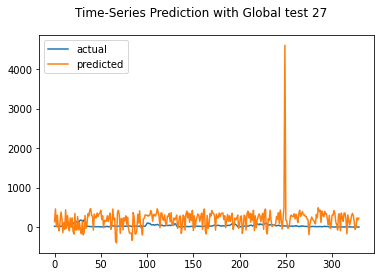

Test MAE: 77.585
Test RMSE: 469.642
Test sMAPE: 99.842
Test R Squared: -227.232
{'mae': 77.58497384389241, 'rmse': 469.6421248163314, 'smape': 99.8422360783277, 'r2': -227.2317657287313}


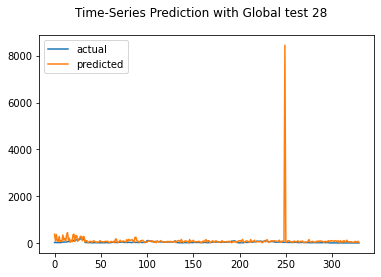

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 64.643
Test RMSE: 85.215
Test sMAPE: 124.401
Test R Squared: -6.514
{'mae': 64.6430171412049, 'rmse': 85.21522519851055, 'smape': 124.40072768504236, 'r2': -6.51409002137498}


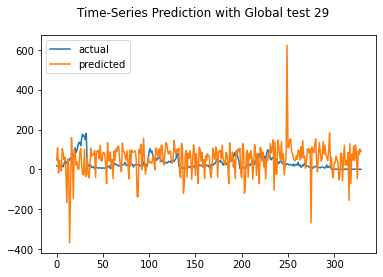

In [ ]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]


calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')